In [1]:
import os
import urllib3 
import json
import requests
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from nltk import bigrams, trigrams
import io
import re
import seaborn as sns
import matplotlib.pyplot as plt

ideas: 
    average(mode?) num of words pro character, graph

# 1. GETTING TO KNOW THE DATA

### 1.1. Get the Data

Скачать данные о русском корпусе, достать оттуда список названий пьес.

In [2]:
js_plays = requests.get('https://dracor.org/api/corpora/rus').json()
idx_plays = [x['name'] for x in js_plays['dramas']]

С помощью списка пьес выкачиваем все данные о речи персонажей (по пьесам) и кладем в общийсловарь data.

In [3]:
urllib3.disable_warnings()
http = urllib3.PoolManager()

In [4]:
data = []
for play_name in idx_plays:
    play = http.request('GET', 'https://dracor.org/api/corpora/rus/play/' + play_name +  '/spoken-text-by-character')
    #play = requests.get('https://dracor.org/api/corpora/ger/play/' + play_name + '/spoken-text-by-character').json()
    df = pd.read_csv(io.StringIO(play.data.decode('UTF-8')))
    #df.head()
    #break
    
    name = (play_name + " ") * len(df)
    name = name.split()
    df["play_name"] = name
    
    data.append(df)

In [5]:
full_df = pd.concat(data)

Сбрасываем индекс, чтобы он соответствовал действительности. Оставляем только те строки, в которых тип - персона. Удаляем ненужные столбцы Лэйбл и Тип. Оставляем только те строчки, где гендер жеский или мужской. Меняем женский на 1 и мужской на 0.

In [54]:
full_df[full_df['Type']=='person']                               # leave only those with Type = person
full_df = full_df.drop(['Label', 'Type'], axis=1)                # delete useless columns
full_df = full_df.query("Gender in ['MALE', 'FEMALE']")          # leave only Males and Females
full_df['Gender'] = pd.get_dummies(full_df['Gender'])['FEMALE']  # change Male and Female to 0 and 1 corr
full_df.reset_index(drop=True, inplace=True)                     # reset index to match the real nuber of rows
full_df.head()

,ID,Gender,Text,play_name
0,yakov,0,"Что задумались, Василиса Петровна? Я пришел.\n...",andreyev-ne-ubiy
1,vasilisa_petrovna,1,"Да вот думаю все.\nХолодно. Да, вот думаю все....",andreyev-ne-ubiy
2,kulabukhov,0,"Ага! Так, так! Салон и разговоры, свет и общес...",andreyev-ne-ubiy
3,margarita,1,Вот и я к вам. Да милая ж вы моя Василиса Петр...,andreyev-ne-ubiy
4,feofan,0,"Мир вам, братие и сестры. Где тут сидение покр...",andreyev-ne-ubiy


Чистка. Замена переноса строки на пробел, удаление чего-то, удаление некириллических символов (в т.ч. пунктуации). Сохраняем в отдельую колонку

In [7]:
full_df['t_clean'] = full_df['Text'].apply(
    lambda x: re.sub(r'[^А-Яа-я\ ]', '', re.sub(r'[-\ ]+', r'\ ', re.sub('\n', ' ', x)).lower()))


In [8]:
full_df.head()

,ID,Gender,Text,t_clean
0,inna_aleksandrovna,1,"Звонит, звонит, а все без толку. За четыре дня...",звонит звонит а все без толку за четыре дня хо...
1,petja,0,А кому прийти? Кто пойдет сюда?\nНе до того им...,а кому прийти кто пойдет сюда не до того им чт...
2,zhitov,0,"Да, положение затруднительное. Дороги нет - ка...",да положение затруднительное дороги нет как в ...
3,lunts,0,"не отвечает, ходит.\nОткуда же я могу услышать...",не отвечает ходит откуда же я могу услышать ка...
4,minna,1,Никого нет.,никого нет


### 1.2. Number of words pro person

Create a column to save number of words in each row. The objective is to count the average number of words pro female and pro male characters.

In [9]:
full_df['clean_len'] = full_df['t_clean'].apply(lambda x: len(x.split()))

In [10]:
full_df.head()

,ID,Gender,Text,t_clean,clean_len
0,inna_aleksandrovna,1,"Звонит, звонит, а все без толку. За четыре дня...",звонит звонит а все без толку за четыре дня хо...,2156
1,petja,0,А кому прийти? Кто пойдет сюда?\nНе до того им...,а кому прийти кто пойдет сюда не до того им чт...,923
2,zhitov,0,"Да, положение затруднительное. Дороги нет - ка...",да положение затруднительное дороги нет как в ...,815
3,lunts,0,"не отвечает, ходит.\nОткуда же я могу услышать...",не отвечает ходит откуда же я могу услышать ка...,1335
4,minna,1,Никого нет.,никого нет,2


New DFs based on gender info

In [11]:
df_fem = full_df.query('Gender == 1').reset_index(drop=True)

df_male = full_df.query('Gender == 0').reset_index(drop=True)

Count number of words pro character for males and females

In [12]:
male_words_count = sum(df_male['clean_len'])

fem_words_count = sum(df_fem['clean_len'])

fem_num = len(df_fem)

male_num = len(df_male)

words_pro_fem = fem_words_count//fem_num

words_pro_male = male_words_count//male_num

In [38]:
words_pro_mf = [words_pro_fem, words_pro_male]

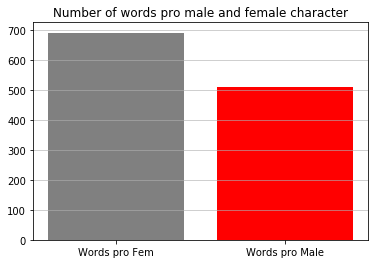

In [39]:
bars = ('Words pro Fem', 'Words pro Male')
y_pos = np.arange(len(bars))

plt.grid(axis='y', alpha=0.75)
plt.bar(y_pos, height=words_pro_mf, color=['grey', 'red'])
plt.xticks(y_pos, bars)
plt.title('Number of words pro male and female character')
plt.show()

In [40]:
total_mf_words = [fem_words_count, male_words_count]

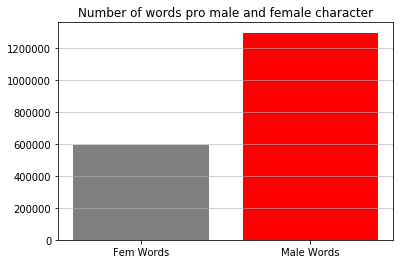

In [41]:
bars = ('Fem Words', 'Male Words')
y_pos = np.arange(len(bars))

plt.grid(axis='y', alpha=0.75)
plt.bar(y_pos, height=total_mf_words, color=['grey', 'red'])
plt.xticks(y_pos, bars)
plt.title('Total Number of Male and Female Words')
plt.show()

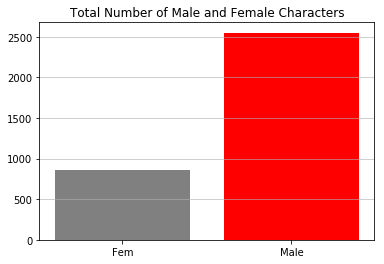

In [42]:
bars = ('Fem', 'Male')
y_pos = np.arange(len(bars))

plt.grid(axis='y', alpha=0.75)
plt.bar(y_pos, height=[fem_num, male_num], color=['grey', 'red'])
plt.xticks(y_pos, bars)
plt.title('Total Number of Male and Female Characters')
plt.show()

### 1.3 Words by Character Hist

In [15]:
hist, bin_edges = np.histogram(full_df['clean_len'])

In [25]:
bins_num = len(full_df['clean_len'])//100
data_h = full_df['clean_len']

In [27]:
bins_num

34

Text(0.5, 1.0, 'Number of Words pro Character Histogram')

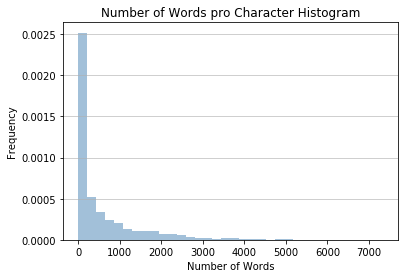

In [28]:
plt.hist(data_h, bins=bins_num, density=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words pro Character Histogram')

In [30]:
male_words_h = df_male['clean_len']
fem_words_h = df_fem['clean_len']

Text(0.5, 1.0, 'Number of Words pro Male vs Female Character Histogram')

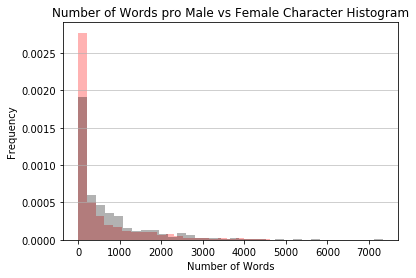

In [44]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=bins_num)

plt.hist(male_words_h,color='red', **kwargs)
plt.hist(fem_words_h,color='black', **kwargs)
plt.grid(axis='y', alpha=0.75)

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words pro Male vs Female Character Histogram')

### 1.4 Average phrase lengh

<p>Most freq male word **нет** most freq fem word **да**.</p>
<p>Most freq **phrase len 6**</p>
<p>Mode and median for fem\male **phrase len 6**</p>
<p>Average male len **9.464965848576059**</p>
<p>Average fem len **9.90394627756591**</p>
<p>Max male phrase len **882**</p>
<p>Max fem phrase len **607**</p>
<p>Max num pro pers fem lines **1410**</p>
<p>Max num pro pers male lines **2254**</p>
<p>Mean num pro fem lines **86.7**</p>
<p>Mean num pro male lines **62.96**</p>
<p>Mode num pro fem lines **1**</p>
<p>Mode num pro male lines **1**</p>
<p>Median num pro fem lines **36**</p>
<p>Median num pro male lines **18**</p>

In [6]:
df_aphl = pd.concat(data)

In [7]:
df_aphl[df_aphl['Type']=='person']                               # leave only those with Type = person
df_aphl = df_aphl.drop(['Label', 'Type'], axis=1)                # delete useless columns
df_aphl = df_aphl.query("Gender in ['MALE', 'FEMALE']")          # leave only Males and Females
df_aphl['Gender'] = pd.get_dummies(df_aphl['Gender'])['FEMALE']  # change Male and Female to 0 and 1 corr
df_aphl.reset_index(drop=True, inplace=True)                     # reset index to match the real nuber of rows

Make column with author name

In [8]:
authors = []

for idx, row in df_aphl.iterrows():
    
    pl_name = row["play_name"]
    author = pl_name.split('-')
    authors.append(author[0])

df_aphl["author"] = authors

In [9]:
df_aphl.head()

,ID,Gender,Text,play_name,author
0,yakov,0,"Что задумались, Василиса Петровна? Я пришел.\n...",andreyev-ne-ubiy,andreyev
1,vasilisa_petrovna,1,"Да вот думаю все.\nХолодно. Да, вот думаю все....",andreyev-ne-ubiy,andreyev
2,kulabukhov,0,"Ага! Так, так! Салон и разговоры, свет и общес...",andreyev-ne-ubiy,andreyev
3,margarita,1,Вот и я к вам. Да милая ж вы моя Василиса Петр...,andreyev-ne-ubiy,andreyev
4,feofan,0,"Мир вам, братие и сестры. Где тут сидение покр...",andreyev-ne-ubiy,andreyev


In [10]:
df_set_dict = {"ID":[], "Gender":[],"author":[], "play_name":[], "text_split":[]}
df_aphl_splt = pd.DataFrame(df_set_dict)

In [11]:
for idx, row in df_aphl.iterrows():
    aussagen = row["Text"].split("\n")
    
    counter = len(aussagen)
    
    while counter > 0:
        df_aphl_splt = df_aphl_splt.append(pd.DataFrame([{'text_split' : aussagen[len(aussagen)-counter],
                                        'ID' : row['ID'],              
                                        'Gender' :    row['Gender'],
                                        "author": row["author"],
                                        "play_name": row["play_name"],}]), sort=False)
        counter = counter - 1    

In [15]:
df_fem_aus_splt = df_aphl_splt.query('Gender == 1').reset_index(drop=True)
df_male_aus_splt = df_aphl_splt.query('Gender == 0').reset_index(drop=True)

In [16]:
df_fem_aus_splt["split_len"] = df_fem_aus_splt["text_split"].apply(lambda x: len(x.split(" ")))
df_male_aus_splt["split_len"] = df_male_aus_splt["text_split"].apply(lambda x: len(x.split(" ")))

#### Stats len(line) & num(lines)

In [27]:
df_fem_aus_splt['ID'].value_counts().median()

36.0

In [28]:
df_male_aus_splt['ID'].value_counts().median()

18.0

In [36]:
df_male_aus_splt["split_len"].mean()

9.464965848576059

In [37]:
df_male_aus_splt["split_len"].max()

882

In [38]:
df_male_aus_splt.mode()

,ID,Gender,Text,text_split,split_len
0,boris_godunov,0.0,NaN,Нет.,6


In [40]:
df_male_aus_splt.median()

Gender       0.0
Text         NaN
split_len    6.0
dtype: float64

In [13]:
df_fem_aus_splt["split_len"].mean()

9.90394627756591

In [30]:
df_fem_aus_splt["split_len"].max()

607

In [32]:
df_fem_aus_splt.mode()

,ID,Gender,Text,text_split,split_len
0,marina,1.0,NaN,Да.,6


In [41]:
df_fem_aus_splt.median()

Gender       1.0
Text         NaN
split_len    6.0
dtype: float64

In [16]:
df_male_aus_splt = df_male_aus_splt.query('split_len > 0').reset_index(drop=True)

In [18]:
data_aus_fem = df_fem_aus_splt["split_len"]

In [25]:
df_fem_aus_splt["split_len"].max()

607

In [27]:
df_fem_aus_splt["split_len"].mode()

0    6
dtype: int64

In [26]:
df_male_aus_splt["split_len"].max()

882

In [19]:
data_aus_fem_freq = np.array(df_fem_aus_splt["split_len"].value_counts())

Text(0.5, 1.0, 'Number of Female Words pro Line Hist')

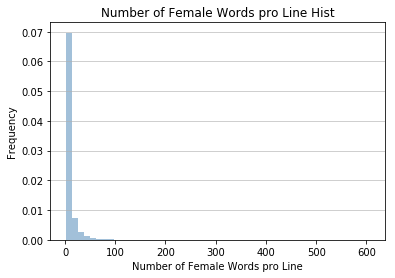

In [24]:
plt.hist(data_aus_fem, bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Female Words pro Line')
plt.ylabel('Frequency')
plt.title('Number of Female Words pro Line Hist')

In [36]:
data_aus_male = df_male_aus_splt["split_len"]

Text(0.5, 1.0, 'Number of Male Words pro Line Hist')

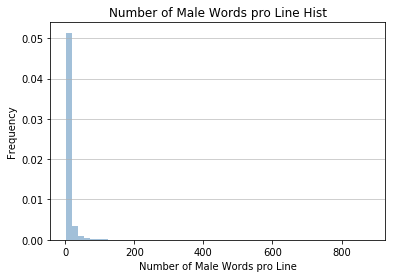

In [37]:
plt.hist(data_aus_male, bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Male Words pro Line')
plt.ylabel('Frequency')
plt.title('Number of Male Words pro Line Hist')

## 1.5 Stats pro Author

### Absolute Number of (Fe)male Lines by Author Distribution

In [38]:
num_fem_lines_by_author_count = df_fem_aus_splt['author'].value_counts()

Text(0.5, 1.0, 'Absolute Number of Female Lines by Author Distribution')

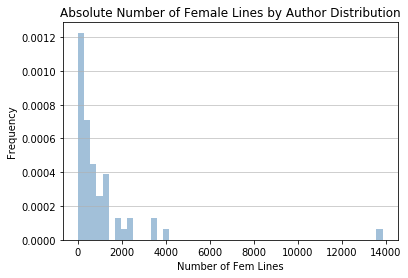

In [39]:
plt.hist(num_fem_lines_by_author_count, bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Fem Lines')
plt.ylabel('Frequency')
plt.title('Absolute Number of Female Lines by Author Distribution')

In [36]:
num_male_lines_by_author_count = df_male_aus_splt['author'].value_counts()

Text(0.5, 1.0, 'Absolute Number of Male Lines by Author Distribution')

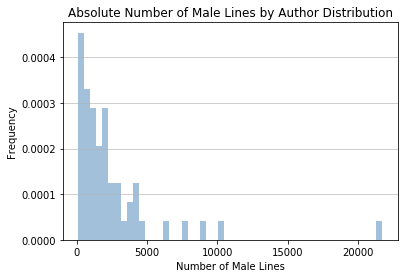

In [37]:
plt.hist(num_male_lines_by_author_count, bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Male Lines')
plt.ylabel('Frequency')
plt.title('Absolute Number of Male Lines by Author Distribution')

### Metrics by Author DataFrame

In [11]:
author_names = df_aphl["author"].unique()

In [12]:
author_names

array(['andreyev', 'artsybashev', 'afinogenov', 'babel', 'belsky', 'blok',
       'bulgakov', 'glinka', 'gogol', 'gorky', 'griboyedov', 'gumilyov',
       'dashkova', 'ekaterina', 'zagoskin', 'kapnist', 'kedrin',
       'knyazhnin', 'kokoshkin', 'kropotov', 'krylov', 'lazhechnikov',
       'lensky', 'lermontov', 'leskov', 'lomonosov', 'majkov', 'mamin',
       'mayakovsky', 'merezhkovsky', 'naydyonov', 'nekrasov', 'nikolev',
       'ozerov', 'ostrovsky', 'petrov', 'pisarev', 'pisemskij',
       'plavilshchikov', 'prutkov', 'pushkin', 'rostopchina', 'saltykov',
       'sollogub', 'sudovshchikov', 'sumarokov', 'sukhovo', 'tolstoy',
       'tretyakov', 'turgenev', 'fonvizin', 'kheraskov', 'khlebnikov',
       'khmelnitsky', 'chekhov', 'shakhovskoy'], dtype=object)

In [13]:
#df_by_author_set_dict = {"author":[], "num_lines":[],:[], "num_lines_pro_pers":[], "text_split":[]}

In [14]:
words_pro_author = {}

In [15]:
for idx, value in df_aphl.iterrows():
    
    author = value['author']
    num_of_words = len(value['Text'].split())
    
    if author not in words_pro_author:
        words_pro_author[author] = num_of_words
    
    else:
        words_pro_author[author] += num_of_words

In [16]:
max(words_pro_author, key=words_pro_author.get)

'ostrovsky'

In [17]:
words_pro_author

{'andreyev': 38519,
 'artsybashev': 15573,
 'afinogenov': 11516,
 'babel': 12934,
 'belsky': 5075,
 'blok': 7155,
 'bulgakov': 99950,
 'glinka': 8257,
 'gogol': 53306,
 'gorky': 31611,
 'griboyedov': 17482,
 'gumilyov': 10918,
 'dashkova': 6461,
 'ekaterina': 23015,
 'zagoskin': 14137,
 'kapnist': 24057,
 'kedrin': 10611,
 'knyazhnin': 86862,
 'kokoshkin': 12952,
 'kropotov': 9082,
 'krylov': 67710,
 'lazhechnikov': 9747,
 'lensky': 9480,
 'lermontov': 42278,
 'leskov': 23729,
 'lomonosov': 19991,
 'majkov': 17486,
 'mamin': 28165,
 'mayakovsky': 21435,
 'merezhkovsky': 13979,
 'naydyonov': 10659,
 'nekrasov': 15369,
 'nikolev': 11732,
 'ozerov': 11995,
 'ostrovsky': 439086,
 'petrov': 10834,
 'pisarev': 22873,
 'pisemskij': 13547,
 'plavilshchikov': 14508,
 'prutkov': 9471,
 'pushkin': 24038,
 'rostopchina': 14985,
 'saltykov': 15379,
 'sollogub': 8448,
 'sudovshchikov': 10593,
 'sumarokov': 86674,
 'sukhovo': 44291,
 'tolstoy': 77127,
 'tretyakov': 3547,
 'turgenev': 88914,
 'fonvizi

In [18]:
df_words_pro_author = pd.DataFrame.from_dict(words_pro_author, orient='index',columns=['number_of_words'])

In [ ]:
df_words_pro_author.sort_values(by='number_of_words', axis=0, ascending=False)

# 2. PREPROCESSING

## 2.1 Peprocessing for author dataframe

clean the text from punctuation and non-cyrillic symbols

In [10]:
df_aphl['t_clean'] = df_aphl['Text'].apply(
    lambda x: re.sub(r'[^А-Яа-я\ ]', '', re.sub(r'[-\ ]+', r'\ ', re.sub('\n', ' ', x)).lower()))

In [11]:
df_aphl.head()

,ID,Gender,Text,play_name,author,t_clean
0,yakov,0,"Что задумались, Василиса Петровна? Я пришел.\n...",andreyev-ne-ubiy,andreyev,что задумались василиса петровна я пришел ну д...
1,vasilisa_petrovna,1,"Да вот думаю все.\nХолодно. Да, вот думаю все....",andreyev-ne-ubiy,andreyev,да вот думаю все холодно да вот думаю все ты з...
2,kulabukhov,0,"Ага! Так, так! Салон и разговоры, свет и общес...",andreyev-ne-ubiy,andreyev,ага так так салон и разговоры свет и общество ...
3,margarita,1,Вот и я к вам. Да милая ж вы моя Василиса Петр...,andreyev-ne-ubiy,andreyev,вот и я к вам да милая ж вы моя василиса петро...
4,feofan,0,"Мир вам, братие и сестры. Где тут сидение покр...",andreyev-ne-ubiy,andreyev,мир вам братие и сестры где тут сидение покреп...


lemmatize everything but past tense verbs in singular female form

In [12]:
m = Mystem()

In [13]:
def special_lemmatization(text):

    lemm_but_fem_line = []
    
    annal_string = m.analyze(text)

    for i in range(0, len(annal_string)-1, 2):
 
        if ('analysis' in annal_string[i]) and (annal_string[i]['analysis'] != [])  and (annal_string[i]['analysis'][0] != None) and ('V,пе=прош,ед,изъяв,жен' in annal_string[i]['analysis'][0]['gr']):
            lemm_but_fem_line.append(annal_string[i]['text'])
            lemm_but_fem_line.append(' ')
        
        elif ('analysis' in annal_string[i]) and (annal_string[i]['analysis'] != []):
            lemm_but_fem_line.append(annal_string[i]['analysis'][0]['lex'])
            lemm_but_fem_line.append(' ')
            
        else:
            lemm_but_fem_line.append(annal_string[i]['text'])
            lemm_but_fem_line.append(' ')
            
        
    return lemm_but_fem_line

In [14]:
df_aphl['t_lem_but_fem'] =df_aphl['t_clean'].apply(lambda x: ''.join(special_lemmatization(x)).strip('\n'))

In [15]:
df_aphl.head()

,ID,Gender,Text,play_name,author,t_clean,t_lem_but_fem
0,yakov,0,"Что задумались, Василиса Петровна? Я пришел.\n...",andreyev-ne-ubiy,andreyev,что задумались василиса петровна я пришел ну д...,что задумываться василиса петровна я приходить...
1,vasilisa_petrovna,1,"Да вот думаю все.\nХолодно. Да, вот думаю все....",andreyev-ne-ubiy,andreyev,да вот думаю все холодно да вот думаю все ты з...,да вот думать все холодно да вот думать все ты...
2,kulabukhov,0,"Ага! Так, так! Салон и разговоры, свет и общес...",andreyev-ne-ubiy,andreyev,ага так так салон и разговоры свет и общество ...,ага так так салон и разговор свет и общество ч...
3,margarita,1,Вот и я к вам. Да милая ж вы моя Василиса Петр...,andreyev-ne-ubiy,andreyev,вот и я к вам да милая ж вы моя василиса петро...,вот и я к вы да милый ж вы мой василиса петров...
4,feofan,0,"Мир вам, братие и сестры. Где тут сидение покр...",andreyev-ne-ubiy,andreyev,мир вам братие и сестры где тут сидение покреп...,мир вы братий и сестра где тут сидение покрепш...


In [16]:
df_aphl["len_lem"] = df_aphl['t_lem_but_fem'].apply(lambda x: len(x.split()))

In [31]:
df_aphl['len_lem'].max()

7325

In [32]:
df_aphl['len_lem'].mean()

543.7692307692307

In [33]:
df_aphl['len_lem'].median()

149.0

In [19]:
df_aphl_short = df_aphl.query('len_lem > 140')

## 2.2 Ostrovsky DF

<p>For characters with no less that 140 words per play</p>

In [ ]:
columns = ['ID', 'Gender', 'Text', 'play_name', 't_clean', 't_lem_but_fem']
ostrovsky_df = pd.DataFrame(columns=columns)

In [56]:
ostrovsky_df

,ID,Gender,Text,play_name,t_clean,t_lem_but_fem


In [57]:
for idx, value in df_aphl_short.iterrows():
    
    if value['author'] == 'ostrovsky':
        print(True)
        ostrovsky_df = ostrovsky_df.append(value)
        #break

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [59]:
ostrovsky_df.head()

,ID,Gender,Text,play_name,t_clean,t_lem_but_fem,author,len_lem
1644,balzaminova,1,"Хорошо теперь, Матрена, чайку-то, после бани-т...",ostrovsky-za-chem-pojdesh-to-i-najdesh,хорошо теперь матрена чайку то после бани то а...,хорошо теперь матрена чайка то после баня то а...,ostrovsky,1835.0
1645,matrena,1,"Уж это на что лучше! По всем жилкам, по всем с...",ostrovsky-za-chem-pojdesh-to-i-najdesh,уж это на что лучше по всем жилкам по всем сус...,уж это на что хорошо по весь жилка по весь сус...,ostrovsky,531.0
1646,balzaminov,0,"Что же это такое, маменька! Помилуйте! На само...",ostrovsky-za-chem-pojdesh-to-i-najdesh,что же это такое маменька помилуйте на самом и...,что же это такой маменька помиловать на самый ...,ostrovsky,3499.0
1647,krasavina,1,"С повинной, матушка! Не вели казнить, вели реч...",ostrovsky-za-chem-pojdesh-to-i-najdesh,с повинной матушка не вели казнить вели речь г...,с повинный матушка не вести казнить вести речь...,ostrovsky,2266.0
1648,chebakov,0,"Что это вы? Что это вы, господин Бальзаминов?\...",ostrovsky-za-chem-pojdesh-to-i-najdesh,что это вы что это вы господин бальзаминов пос...,что это вы что это вы господин бальзамин послу...,ostrovsky,493.0


# 3. Vectorization

## 3.1. Train/test split

For df_aphl_short

In [17]:
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV)

In [20]:
data = df_aphl_short['t_lem_but_fem'].tolist()
target = df_aphl_short['Gender']

In [21]:
X_train, X_test, y_train, y_test =\
    train_test_split(data, target,
                     test_size=0.2, shuffle=True, random_state=42, stratify=target)

## 3.2. BOW CountVectorizer

Vectorization for df_aphl_short

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [100]:
vectorizer = CountVectorizer()#ngram_range=(1,5), min_df=100, max_df=0.7)

In [101]:
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
vocabulary = np.array(vectorizer.get_feature_names())

In [102]:
len(vocabulary.tolist())

39075

## 3.3. Ostrovsky Split & Vectorization

### 3.3.1 Train/Test split

In [80]:
data_ost = ostrovsky_df['t_lem_but_fem'].tolist()
target_ost = ostrovsky_df['Gender']
target_ost = target_ost.astype('int')

In [81]:
X_train_ost, X_test_ost, y_train_ost, y_test_ost =\
    train_test_split(data_ost, target_ost,
                     test_size=0.2, shuffle=True, random_state=42, bstratify=target)

In [86]:
len(data_ost)

339

### 3.3.2 Vectorization

In [82]:
vectorizer = CountVectorizer()

In [83]:
X_train_bow_ost = vectorizer.fit_transform(X_train_ost)
X_test_bow_ost = vectorizer.transform(X_test_ost)
vocabulary_ost = np.array(vectorizer.get_feature_names())

### 3.3.3 LogReg

<h4> LogReg for Ostrovsky plays, characters with less than 140 words excluded</h4>
<p>accuracy_logreg_ost, recall_logreg_ost, precision_logreg_ost, f1_logreg_ost</p>
<p>0.8235294117647058 0.8214285714285714 0.7666666666666667 0.793103448275862</p>

In [84]:
logreg_ost =LogisticRegression()

In [89]:
X_test_bow_ost.shape[1]

14284

In [91]:
len(vocabulary_ost.tolist())

14284

In [92]:
len(y_test_ost)

68

In [94]:
X_train_bow_ost.shape[1]

14284

In [95]:
logreg_ost.fit(X_train_bow_ost, y_train_ost)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
y_preds_ost = logreg_ost.predict(X_test_bow_ost)

In [98]:
accuracy_logreg_ost = accuracy_score(y_test_ost, y_preds_ost)
recall_logreg_ost = recall_score(y_test_ost, y_preds_ost)
precision_logreg_ost = precision_score(y_test_ost, y_preds_ost)
f1_logreg_ost = f1_score(y_test_ost, y_preds_ost)

In [99]:
print(accuracy_logreg_ost, recall_logreg_ost, precision_logreg_ost, f1_logreg_ost)

0.8235294117647058 0.8214285714285714 0.7666666666666667 0.793103448275862


# 4. LogReg

LogReg for df_aphl_short 
<p>accuracy_logreg, recall_logreg, precision_logreg, f1_logreg</p>
<p>0.8132183908045977 0.6696428571428571 0.7281553398058253 0.6976744186046512 *(ngram_range=(1,5), min_df=100, max_df=0.7)*</p>
<p>0.8477011494252874 0.6964285714285714 0.8041237113402062 0.7464114832535885 *(default countvec settings)*</p>

In [36]:
import matplotlib as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, precision_score, f1_score
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc, recall_score, accuracy_score)
import time

In [103]:
logreg =LogisticRegression()

In [104]:
logreg.fit(X_train_bow, y_train)
y_preds = logreg.predict(X_test_bow)

In [105]:
accuracy_logreg = accuracy_score(y_test, y_preds)
recall_logreg = recall_score(y_test, y_preds)
precision_logreg = precision_score(y_test, y_preds)
f1_logreg = f1_score(y_test, y_preds)

In [106]:
print(accuracy_logreg, recall_logreg, precision_logreg, f1_logreg)

0.8477011494252874 0.6964285714285714 0.8041237113402062 0.7464114832535885


0.6696428571428571

 *#################################################################################################################*

### 1.2. Lemmatization

In [14]:
#counter = 0
def special_lemmatization(text):

#lemmatizes everything but the singular verbs in past tense in female form 

    #print('@')
    #print()
    #print()    
    #print(counter)
    #print()
    #print()
    
    lemm_but_fem_line = []
    
    annal_string = m.analyze(text)

    for i in range(0, len(annal_string)-1, 2):
        
        #print(annal_string[i])
        #print(i)
        if ('analysis' in annal_string[i]) and (annal_string[i]['analysis'] != [])  and (annal_string[i]['analysis'][0] != None) and ('V,пе=прош,ед,изъяв,жен' in annal_string[i]['analysis'][0]['gr']):
            lemm_but_fem_line.append(annal_string[i]['text'])
            lemm_but_fem_line.append(' ')
        #print(i, annal_string[i])
        
        elif ('analysis' in annal_string[i]) and (annal_string[i]['analysis'] != []):
            lemm_but_fem_line.append(annal_string[i]['analysis'][0]['lex'])
            lemm_but_fem_line.append(' ')
            
        else:
            lemm_but_fem_line.append(annal_string[i]['text'])
            lemm_but_fem_line.append(' ')
            
    #counter = counter + 1
        
    return lemm_but_fem_line#, counter

In [15]:
full_df['t_lem'] = full_df['t_clean'].apply(lambda x: ''.join(special_lemmatization(x)).strip('\n'))

In [16]:
full_df.head()

,ID,Gender,Text,t_clean,t_lem
0,yakov,0,"Что задумались, Василиса Петровна? Я пришел.\n...",что задумались василиса петровна я пришел ну д...,что задумываться василиса петровна я приходить...
1,vasilisa_petrovna,1,"Да вот думаю все.\nХолодно. Да, вот думаю все....",да вот думаю все холодно да вот думаю все ты з...,да вот думать все холодно да вот думать все ты...
2,kulabukhov,0,"Ага! Так, так! Салон и разговоры, свет и общес...",ага так так салон и разговоры свет и общество ...,ага так так салон и разговор свет и общество ч...
3,margarita,1,Вот и я к вам. Да милая ж вы моя Василиса Петр...,вот и я к вам да милая ж вы моя василиса петро...,вот и я к вы да милый ж вы мой василиса петров...
4,feofan,0,"Мир вам, братие и сестры. Где тут сидение покр...",мир вам братие и сестры где тут сидение покреп...,мир вы братий и сестра где тут сидение покрепш...


### 1.3. POS-tagging

21 april 2019

In [17]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [18]:
full_df['t_pos'] = full_df['t_lem'].apply(
    lambda x: ' '.join([i + '_' + str(morph.tag(i)[0].POS) for i in x.split()]))

In [20]:
full_df.head()

,ID,Gender,Text,t_clean,t_lem,t_pos
0,yakov,0,"Что задумались, Василиса Петровна? Я пришел.\n...",что задумались василиса петровна я пришел ну д...,что задумываться василиса петровна я приходить...,что_CONJ задумываться_INFN василиса_NOUN петро...
1,vasilisa_petrovna,1,"Да вот думаю все.\nХолодно. Да, вот думаю все....",да вот думаю все холодно да вот думаю все ты з...,да вот думать все холодно да вот думать все ты...,да_PRCL вот_PRCL думать_INFN все_ADJF холодно_...
2,kulabukhov,0,"Ага! Так, так! Салон и разговоры, свет и общес...",ага так так салон и разговоры свет и общество ...,ага так так салон и разговор свет и общество ч...,ага_INTJ так_CONJ так_CONJ салон_NOUN и_CONJ р...
3,margarita,1,Вот и я к вам. Да милая ж вы моя Василиса Петр...,вот и я к вам да милая ж вы моя василиса петро...,вот и я к вы да милый ж вы мой василиса петров...,вот_PRCL и_CONJ я_NPRO к_PREP вы_NPRO да_PRCL ...
4,feofan,0,"Мир вам, братие и сестры. Где тут сидение покр...",мир вам братие и сестры где тут сидение покреп...,мир вы братий и сестра где тут сидение покрепш...,мир_NOUN вы_NPRO братий_NOUN и_CONJ сестра_NOU...


### 1.5. Chunks

Создаем копию датафрейма, чтоб иметь доступ к обоим вариантам.

In [21]:
df_chunked = full_df.copy(deep = True)
df_chunked = df_chunked.drop(['Text'], axis=1)

Режем на чанки относительно медианы по количеству слов

In [22]:
df_chunked['len_words'] = full_df['t_lem'].apply(lambda x: len(x.split()))

In [23]:
w_median = int(df_chunked['len_words'].median())
print(w_median)

148


In [24]:
for idx, row in df_chunked.query('len_words > @w_median').iterrows():
    
    words = row['t_lem'].split()
    left  = 0
    right = w_median
    
    while right < len(words):
        
        df_chunked = df_chunked.append(pd.DataFrame([{'t_clean' : ' '.join(words[left:right]),
                                        'ID' : row['ID'],
                                        't_lem' : row['t_lem'],
                                        't_pos' : row['t_pos'],              
                                        'Gender' :    row['Gender'], 'len_words': right-left}]), sort=False)
        left += w_median
        right += w_median
    
    df_chunked = df_chunked.append(pd.DataFrame([{'t_clean' : ' '.join(words[left:]),
                                    'ID' : row['ID'],
                                    't_lem' : row['t_lem'],
                                    't_pos' : row['t_pos'], 
                                    'Gender' :    row['Gender'], 'len_words': len(words)-left}]), sort=False)
    

df_chunked = df_chunked.query('len_words <= @w_median').reset_index(drop=True)

In [25]:
df_chunked = df_chunked.query('len_words == 148').reset_index(drop=True)

In [26]:
df_chunked['len_words'].max()

148

drop lem and pos bc they were not cut properly, recount lem

In [27]:
df_chunked = df_chunked.drop(['t_lem', 't_pos'], axis=1)

In [28]:
df_chunked['t_lem'] = df_chunked['t_clean'].apply(lambda x: ''.join(special_lemmatization(x)).strip('\n'))

In [37]:
#for i in range(10):
#    print(i)
#    print('gender' + ' ' + str(df_chunked['Gender'][i]))
#    print(df_chunked['t_lem'][i])
#    print()

In [33]:
df_chunked.head()

,ID,Gender,t_clean,len_words,t_lem
0,EscheLiterator,0,поверьте мне я знаю это дело отвратительная пь...,148,поверять я я знать этот дело отвратительный пь...
1,elizaveta,1,они пьют как воробушки а там булычов рычит сл...,148,они пить как воробушек а там булычовый рычать ...
2,yakov,0,что задумываться василиса петровна я приходить...,148,что задумываться василиса петровна я приходить...
3,yakov,0,я это увидеть а сейчас спать что ж можно и на ...,148,я это увидеть а сейчас спать что ж можно и на ...
4,yakov,0,такой не находить другой что походить я повида...,148,такой не находить другой что походить я повида...


In [34]:
df_chunked['Gender'].value_counts()

0    7613
1    3616
Name: Gender, dtype: int64

# 2. MODELS

### 2.1 Train/test Split

I split for train\test with a stable random state, shuffle it and stratify according to the tagdet (male/female)

In [35]:
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV)

In [36]:
data = df_chunked['t_lem'].tolist()
target = df_chunked['Gender']

In [37]:
X_train, X_test, y_train, y_test =\
    train_test_split(data, target,
                     test_size=0.2, shuffle=True, random_state=42, stratify=target)

In [ ]:
data[0]

In [ ]:
len(data[2])

In [108]:
len(X_train)

8983

In [131]:
len(y_train)

8983

In [132]:
len(y_test)

2246

In [109]:
len(X_test)

2246

In [110]:
lem_len = df_chunked['t_lem'].apply(lambda x: len(x.split()))

In [111]:
max(lem_len)

148

'якого полка якого полка нога поморозить а чом же це ты не взять посвидченье вид штаб свой полк а якого полк знать вы сечевик вси зрадник изменник большевик скидать сапог скидать и если ты не поморозить нога а брехать то я ты тут же расстреливать хлопец фонарь и вот ты условие нога здоровый быть ты у я на тот свет отходить сзади чтобы я в кто нибудь не попадать записка треба було узять записка мразь а не бежать из полк взять он под арест и под арест до лазарет як он ликарь нога перевязывать вернуть он сюд в штаб и давать он пятнадцать шомполив щоба вино знать як без документ бегать с свой полк хлопец що там що хлопец разведка по конь по конь садиться садиться кирпатый а ну проскачить за они тилька живой вызьмить живой с что задерживать що товарищ кто ж тут ты товарищ я ты не господин господин все с гетман в город сейчас и мы твой господин кишка повыматывать хлопец давать он ты близкий урезать этот господин по шея теперь бачить як господин тут видеть освещать он хлопец мень щесь здаться

### 2.2. Vectorization

### 2.2.1. BOW

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [160]:
vectorizer = CountVectorizer(ngram_range=(1,5))#, min_df=100, max_df=0.7)

First I have decided to vectorize the POS-tagged text, taking into account only those words that have high document friquency. I assume that they will mostly be prepositions and other auxiliary parts of speech. I will find out  below if my assumption is correct.

In [161]:
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
vocabulary = np.array(vectorizer.get_feature_names())

In [162]:
len(vocabulary.tolist())

3802453

In [163]:
vectorizer.get_feature_names()

['аа',
 'аа его',
 'аа его попечение',
 'аа его попечение около',
 'аа его попечение около то',
 'аа ну',
 'аа ну господин',
 'аа ну господин теперь',
 'аа ну господин теперь урок',
 'ааа',
 'ааа вы',
 'ааа вы не',
 'ааа вы не мочь',
 'ааа вы не мочь отвечайт',
 'ааа седой',
 'ааа седой борода',
 'ааа седой борода шкилет',
 'ааа седой борода шкилет не',
 'ааа теперь',
 'ааа теперь понимать',
 'ааа теперь понимать ну',
 'ааа теперь понимать ну если',
 'аааа',
 'аааа ах',
 'аааа ах ты',
 'аааа ах ты боже',
 'аааа ах ты боже мой',
 'ааствовать',
 'ааствовать милый',
 'ааствовать милый хороший',
 'ааствовать милый хороший мой',
 'ааствовать милый хороший мой чернобровый',
 'абба',
 'абба россия',
 'абба россия говорить',
 'абба россия говорить рождаться',
 'абба россия говорить рождаться не',
 'аббас',
 'аббас он',
 'аббас он приязнь',
 'аббас он приязнь то',
 'аббас он приязнь то более',
 'аббас рад',
 'аббас рад дружба',
 'аббас рад дружба пребывать',
 'аббас рад дружба пребывать но',
 '

In [166]:
X_train_bow.shape[0]

8983

In [165]:
len(X_train)

8983

In [135]:
X_train_bow

<8984x1698 sparse matrix of type '<class 'numpy.int64'>'
	with 669876 stored elements in Compressed Sparse Row format>

### 2.2.2. TF-IDF

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5), min_df=100, max_df=0.5)

In [119]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
tfidf_vocabulary = np.array(tfidf_vectorizer.get_feature_names())

In [120]:
len(tfidf_vocabulary.tolist())

1701

### 2.3. LogReg RFC

### 2.3.1. BOW

In [121]:
import matplotlib as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, precision_score
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc, recall_score)
import time

In [122]:
# fit log-reg and rfc

# fit log-reg and rfc
models = [LogisticRegression(), RandomForestClassifier(n_estimators=200)]
names = ['logistic_regression', 'random_forest']
metrics_func = [accuracy_score, precision_score, recall_score]
metrics_name = ['accuracy', 'precision', 'recall']
y_preds = np.zeros((len(X_test), len(models)))  # matrix to store metric data
dur_time = np.zeros(len(models))  # matrix to store time

for i in range(len(models)):
    start_time = time.time()
    models[i].fit(X_train_bow, y_train)
    dur_time[i] = time.time() - start_time
    y_preds[:, i] = models[i].predict(X_test_bow)

%store dur_time
%store names

Stored 'dur_time' (ndarray)
Stored 'names' (list)


In [123]:
# data to a DF
df_scores = pd.DataFrame.from_dict({
    i*len(metrics_name) + j: [names[i], metrics_name[j], metrics_func[j](
        y_test, y_preds[:, i])]
    for i in range(len(names))
    for j in range(len(metrics_name))
}, orient='index')
df_scores.columns = ['model', 'metric', 'score']

%store df_scores
df_scores


Stored 'df_scores' (DataFrame)


,model,metric,score
0,logistic_regression,accuracy,0.740873
1,logistic_regression,precision,0.601732
2,logistic_regression,recall,0.576763
3,random_forest,accuracy,0.723508
4,random_forest,precision,0.844595
5,random_forest,recall,0.172891


### 2.3.2. TF-IDF

In [124]:
# fit log-reg and rfc
models = [LogisticRegression(), RandomForestClassifier(n_estimators=200)]
names = ['logistic_regression', 'random_forest']
metrics_func = [accuracy_score, precision_score, recall_score, auc]
metrics_name = ['accuracy', 'precision', 'recall']
y_preds = np.zeros((len(X_test), len(models)))  # matrix to store metric data
dur_time = np.zeros(len(models))  # matrix to store time

for i in range(len(models)):
    start_time = time.time()
    models[i].fit(X_train_tfidf, y_train)
    dur_time[i] = time.time() - start_time
    y_preds[:, i] = models[i].predict(X_test_tfidf)

%store dur_time
%store names

Stored 'dur_time' (ndarray)
Stored 'names' (list)


In [125]:
# data to a DF
df_scores = pd.DataFrame.from_dict({
    i*len(metrics_name) + j: [names[i], metrics_name[j], metrics_func[j](
        y_test, y_preds[:, i])]
    for i in range(len(names))
    for j in range(len(metrics_name))
}, orient='index')
df_scores.columns = ['model', 'metric', 'score']

%store df_scores
df_scores


Stored 'df_scores' (DataFrame)


,model,metric,score
0,logistic_regression,accuracy,0.772039
1,logistic_regression,precision,0.708911
2,logistic_regression,recall,0.495159
3,random_forest,accuracy,0.720392
4,random_forest,precision,0.810458
5,random_forest,recall,0.171508


## 2.4. Keras

In [126]:
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import StratifiedKFold

/home/taorkon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [127]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [128]:
data_keras = np.array(data)
target_keras = np.array(target)

### *With cross-validation*

In [129]:
for train,test in skf.split(data_keras, target_keras):
    
    #print(data_keras[train], type(data_keras[train]))
    
    X_train_bow = vectorizer.fit_transform(data_keras[train])
    X_test_bow = vectorizer.transform(data_keras[test])
    
    input_dim = X_train_bow.shape[1]  # Number of features

    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()

    history = model.fit(X_train_bow, target_keras[train],
                        epochs=10, verbose=False,
                        validation_data=(X_test_bow, target_keras[test]),
                        batch_size=10)

    loss, accuracy = model.evaluate(X_train_bow, target_keras[train], verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_bow, target_keras[test], verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Training Accuracy: 0.9924
Testing Accuracy:  0.7655
Training Accuracy: 0.9874
Testing Accuracy:  0.7560
Training Accuracy: 0.9804
Testing Accuracy:  0.7395
Training Accuracy: 0.9895
Testing Accuracy:  0.7541
Training Accuracy: 0.9898
Testing Accuracy:  0.7403


### *Without Cross_validation*

In [130]:
input_dim = X_train_bow.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

history = model.fit(
    X_train_bow, y_train,epochs=10, verbose=False,
    validation_data=(X_test_bow, y_test),batch_size=10)

loss, accuracy = model.evaluate(X_train_bow, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_bow, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

ValueError: Input arrays should have the same number of samples as target arrays. Found 8984 input samples and 8983 target samples.

test on famous char (and check probability)

1. not to lemmatize words with female morphemes
2. check if there are more of those words in fem speech
3. think of ways to split male dataset
4. check tense distribution
5. test on contemporary/modern fem speech
6. find examples that do not work in the alg
7. try to give unknown to the alg

1. somr stats for the speeches

In [ ]:
#try xg boost